# Sentiment Analysis
We create a ML model to analyze sentiments based on SVM (Support Vector Mehtod). The input to SVM is the document matrix, where the rows are comments by each user and the columns are the tokenized comments words after processing

In [1]:
%matplotlib inline
%timeit
import sys
sys.path.append('pymodules')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils
import pymodules.CustomClassifier as CustomClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error

from timeit import default_timer as timer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Read file that contains user reviews
* Pre-process the comments
* All pre-processing steps have been explained in Exploratory Data Analysis
* The output is a dataframe and tokens corresponding to each user's comments

In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Read sheet 'Scrubbed_data' ...
Columns:Index(['TITLE', 'COMMENTS', 'OVERALL_RATING', 'COMFORT_RATING',
       'VISION_RATING', 'VALUE_FOR_MONEY', 'AUTHOR', 'PROS', 'CONS',
       'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'FINAL_PRODUCT_NAME',
       'PRODUCT_LINK', 'WEBSITE', 'RATING', 'PRODUCT', 'BRAND'],
      dtype='object')
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index

### We use bigrams to augment our tokens to extract meaningful sentiments both positive and negative.
* We don't use trigrams for now, but it is subject to requirements and further analysis

In [3]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['used', 'for', 'long', 'time', 'and', 'say', 'service', 'from', 'com', 'great', 'and', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'used-for', 'for-long', 'long-time', 'time-and', 'and-say', 'say-service', 'service-from', 'from-com', 'com-great', 'great-and', 'and-work', 'work-great', 'great-for', 'for-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'again', 'order', 'came', 'fast', 'without', 'any', 'issues', 'and', 'candy', 'nice', 'touch', 'buy-again', 'again-order', 'order-came', 'came-fast', 'fast-without', 'without-any', 'any-issues', 'issues-and', 'and-candy', 'candy-nice', 'nice-touch']


In [4]:
len(prep_comments.tokens)

8794

### Vectorization
* TF-IDF weights more words that occur frequently but in lesser number of documents. This seems to skew ranking towards advertisement like reviews. In any case for SVM, we use the count of tokens to establish a baseline accuracy of model, prior to using RNN model.

In [5]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# create a CountVectorizer object using our preprocessed text
# uni gram
count_vectorizer = CountVectorizer(encoding='utf-8',
                                   preprocessor=do_nothing,  # apply no additional preprocessing
                                   tokenizer=do_nothing,     # apply no additional tokenization
                                   lowercase=False,
                                   strip_accents=None,
                                   stop_words=None,
                                   ngram_range=(1, 1),       # generate only unigrams
                                   analyzer='word',          # analysis at the word-level
                                   #max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
                                   #min_df=500,                # ignore tokens that have a lowe document frequency (can be int or percent)
                                   min_df=10,
                                   max_features=None,        # we could impose a maximum number of vocabulary terms
                                   )


In [6]:
# transform our preprocessed tokens into a document-term matrix
dt_matrix = count_vectorizer.fit_transform(prep_comments.tokens)
print(f"Document-term matrix created with shape: {dt_matrix.shape}")

Document-term matrix created with shape: (8794, 1643)


In [7]:
# we can access a dictionary that maps between words and positions of the document-term matrix. We need this for SVM in order to make the word itself as column of dataframe (see output)
id_word_indexer = pd.DataFrame(count_vectorizer.vocabulary_.items())
id_word_indexer

,0,1
0,used,1499
1,for,612
2,long,864
3,time,1434
4,and,59
...,...,...
1638,vertex-toric,1516
1639,preference-toric,1135
1640,vertex-sphere,1515
1641,proclear-multifocal,1170


In [8]:
## FOR SVM, we need to make a matrix with proper column names
# Also, we need another column that denotes the review
# We also need to normalize the data
df_svm = pd.DataFrame(dt_matrix.toarray())
df_svm.rename(columns=id_word_indexer.to_dict()[0], inplace=True)
df_svm

,used,for,long,time,and,say,service,from,com,great,...,ultra-for,aspheric,frequency-aspheric,encore,vertex,vertex-toric,preference-toric,vertex-sphere,proclear-multifocal,proclear-toric
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT
REVIEW_DATE,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...
...,...,...,...,...,...,...
2021-11-29,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic..."
2021-11-23,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...
2021-12-27,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...


2    8386
0     336
1      72
Name: _SENTIMENT_, dtype: int64


[[Text(0, 0, '>3'), Text(1, 0, '<3'), Text(2, 0, '=3')]]

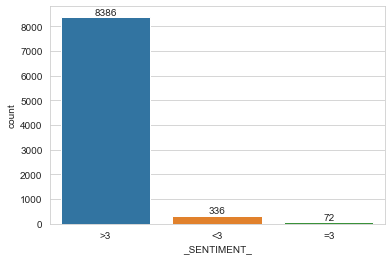

In [10]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

SENTIMENT_SERIES = df['RATING'].apply(find_sentiment).astype('category')
df_svm['_SENTIMENT_'] = SENTIMENT_SERIES.values
df_svm['_SENTIMENT_'] = df_svm['_SENTIMENT_'].astype('category')
sentiments = df_svm._SENTIMENT_.value_counts()
print(sentiments)

import seaborn as sns
ax = sns.countplot(x=df_svm['_SENTIMENT_'], order=df_svm['_SENTIMENT_'].value_counts(ascending=False).index)
abs_values = df_svm['_SENTIMENT_'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set(xticklabels=['>3', '<3', '=3'])

In [11]:
X = df_svm.drop(['_SENTIMENT_'], axis=1)
y = df_svm['_SENTIMENT_']
validation_reqd = True
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation=True)

### Null accuracy
This is the accuracy based on the proportion of input distribution of sentiment values.
Any ML algorithm, to be useful, should have better results than this.

In [12]:
rating_counts = y.value_counts()
dn = np.sum(rating_counts)
null_rating_lt_3 = round((rating_counts[0]/dn)* 100, 3)
null_rating_eq_3 = round((rating_counts[1]/dn)* 100, 3)
null_rating_gt_3 = round((rating_counts[2]/dn)* 100, 3)
print(f"Pct. Rating < 3, corresponding to code 0 is: {null_rating_lt_3}%")
print(f"Pct. Rating = 3, corresponding to code 0 is: {null_rating_eq_3}%")
print(f"Pct. Rating > 3, corresponding to code 0 is: {null_rating_gt_3}%")

Pct. Rating < 3, corresponding to code 0 is: 3.821%
Pct. Rating = 3, corresponding to code 0 is: 0.819%
Pct. Rating > 3, corresponding to code 0 is: 95.36%


# Let us fit NULL model

In [13]:
null_model = CustomClassifier.NullClassifier()
null_model_fit = null_model.fit(df_trainX, df_trainy)
y_pred_null = np.array(null_model_fit.predict(df_testX))

# Results of fitting NULL model

              precision    recall  f1-score   support

    negative       0.04      0.95      0.07        83
     neutral       0.01      0.06      0.02        18
    positive       0.86      0.01      0.02      2098

    accuracy                           0.04      2199
   macro avg       0.30      0.34      0.04      2199
weighted avg       0.82      0.04      0.02      2199

[[  79    2    2]
 [  16    1    1]
 [1970  110   18]]


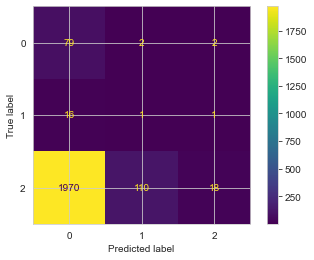

Null Model:Accuracy of model(<3, = 3, >3) is:   [ 9.5  94.13  5.28]%
Null Model:Sensitivity of the test(<3, = 3, >3):[95.18  5.56  0.86]%
Null Model:Specificity of the test(<3, = 3, >3):[ 6.14 94.86 97.03]%
Null Model:Likelihood ratio(<3, = 3, >3):       [1.01 1.08 0.29]


In [14]:
targetnames=['negative', 'neutral', 'positive']
print(metrics.classification_report(df_testy, y_pred_null, target_names=targetnames))
## plot confusion matrix as well
cm = confusion_matrix(df_testy, y_pred_null)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(y_pred_null, df_testy)
print(f'Null Model:Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'Null Model:Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'Null Model:Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'Null Model:Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

### In order to use SVM, we need to normalize column data.
This is because we use distance measure in SVM and for any method that uses distance measure for classification, feature data needs to be normalized so that all features (words in our context)
are treated equally

In [15]:
ss = StandardScaler()
df_trainX = ss.fit_transform(df_trainX)
df_testX = ss.fit_transform(df_testX)
df_validX = ss.fit_transform(df_validX)

### Define the SVM model
Since our dataset response variable is imbalanced, we need to tell the SVM model to "balance" the data
We do this by using the inverse of frequency of sentiments to balance out the skew

In [16]:
# https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
# How to choose C and gamma values ...
# 0.0001 < gamma < 10
# 0.1 < C < 100
# When gamma is large, C does not matter ...

def create_svm_model(trainX, trainy, validX, validy):
    def _create_svm_model(param_dict):
        C = param_dict['C']
        kernel = param_dict['kernel']
        degree = param_dict['degree']

        model = SVC(C=C,
                        kernel=kernel,
                        degree=degree,
                        gamma='auto',
                        class_weight='balanced',
                        random_state=42)


        # fit model ...
        history = model.fit(X=trainX, y=trainy)
            #, validation_data = (validX,validy),
            #                verbose=1,
            #                workers=4,
            #                use_multiprocessing=True)

        y_pred_train = model.predict(trainX)#, workers=4, use_multiprocessing=True)
        y_pred_validation = model.predict(validX)#, workers=4, use_multiprocessing=True)

        #y_train_pred_labels = convert_prob_to_labels(y_pred_train)
        #y_validation_pred_labels = convert_prob_to_labels(y_pred_validation)

        # accuracy score used ...
        train_score = accuracy_score(trainy, y_pred_train)
        val_score = accuracy_score(validy, y_pred_validation)

        return train_score, val_score, param_dict, history, y_pred_validation, model

    return _create_svm_model

### Here we define the search space for determining the optimal SVM model

In [17]:
# parameters to be varied
C = [1.0] #np.logspace(0, 1, 21)
kernel_functions = ['linear'] #('linear', 'poly', 'rbf', 'sigmoid')
degree_vals = [1]

parameters = [{'C': C,
              'kernel': kernel_functions,
              'degree': degree_vals
              }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
[print(x) for x in grid_params]

{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


[None]

### Run the SVM model in parallel and get the best model

In [18]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
svm_model_func = create_svm_model(df_trainX, df_trainy, df_validX, df_validy)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = contacts_utils.run_parallel(svm_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with SVM model: {(end_-st_)/60.0} mins.")

Time taken to finish best parameter search with SVM model: 0.27865861063333336 mins.


### Why SVM ? Why not LR, Naive Bayes as NULL model ?
* LR ans SVM are closesly related. If the idea is to know the probabilities, then LR is a good option. But if the idea is to make the *right decision* (i.e. can be expressed as ratio of likelihoods), we end up with SVM method!
* Naive Bayes assumes *class conditional independence*. In this context, this means, given the sentiments, the features found are independent of each other. This i not true for this problem.
* LDA is very closely related to Naive Bayes with additional assumption of Gaussian distribution of features. So we can ignore this as well.
* What about decision trees and its friends ?
    * No proabilistic distribution assumption on response or features
    * Can be used in offline mode, but with addition of new data, one needs to retrain from scratch

### Find the best model
The best model is found based on the accuracy score of validation data that is used when searching the parameter space of the model

In [19]:
results

[(0.955115244642135,
  0.8289872650090965,
  {'C': 1.0, 'degree': 1, 'kernel': 'linear'},
  SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
      random_state=42),
  array([2, 0, 2, ..., 0, 2, 2]),
  SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
      random_state=42))]

In [20]:
# find the best parameters based on validation score
best_validation_score = results[0][1]
best_params = results[0][2]
plot_data = results[0][3]
best_validation_data = results[0][4]
best_model = results[0][5]
for i in range(1, len(results)):
    tscore = results[i][0]
    vscore = results[i][1]
    param = results[i][2]
    if vscore > best_validation_score:
        best_validation_score = vscore
        best_params = param
        plot_data = results[i][3]
        best_validation_data = results[i][4]
        best_model = results[i][5]

# output result
print(f"Best validation score:{best_validation_score}")
print(f"Best params based on validation score:{best_params}")

Best validation score:0.8289872650090965
Best params based on validation score:{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


### Model metrics for comparison:
Precision (positive predictive value), recall (sensitivity of test)

In [21]:
targetnames=['negative', 'neutral', 'positive']
#y_pred =   np.argmax(y_pred_raw, axis = 1)
#y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(df_validy, best_validation_data, target_names=targetnames))

              precision    recall  f1-score   support

    negative       0.05      0.25      0.09        32
     neutral       0.00      0.00      0.00         6
    positive       0.98      0.84      0.91      1611

    accuracy                           0.83      1649
   macro avg       0.34      0.36      0.33      1649
weighted avg       0.96      0.83      0.89      1649



## Confusion matrix

[[   8    1   23]
 [   2    0    4]
 [ 138  114 1359]]


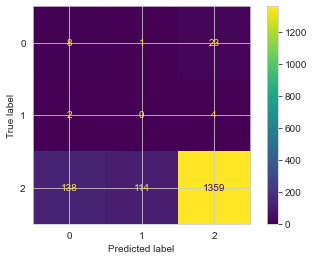

In [22]:
# multi-label plot ...
cm = confusion_matrix(df_validy, best_validation_data)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### Multi label stats
This function extracts Accuracy, Sensitivity, Specificity and Likelihood ratio for each of the 3 sentiment labels

In [23]:
accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(best_validation_data, df_validy)
print(f'Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

Accuracy of model(<3, = 3, >3) is:   [90.05 92.66 83.08]%
Sensitivity of the test(<3, = 3, >3):[25.    0.   84.36]%
Specificity of the test(<3, = 3, >3):[91.34 93.   28.95]%
Likelihood ratio(<3, = 3, >3):       [2.89 0.   1.19]


### Finally, we use the best model and re-run it on the train and test data without any validation data

In [25]:
# We extract the best params from above cells
best_model_params = best_params

# Instead of joining validation data and train data, we simply reload the original data and split then into
# train and test. This is suboptimal, but being relatively fast, this is ok for now
validation_reqd = False
# we want the output to be onehot encoded and this makes it easier to use other activation functions
# other than softmax for the last layer, (as this is a multi-class classification problem)
oneh = True
trainX, trainy, testX, testy, validX, validy = contacts_utils.split_data(X, y, validation_reqd)
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Now run the model with the best params
best_model_nn = create_svm_model(trainX, trainy, testX, testy)
st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
b_train_score, b_val_score, b_param_dict, b_history, y_labels_predicted, best_model = best_model_nn(best_model_params)
end_ = timer()

accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(y_labels_predicted, testy)
print(f'Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

Train: X=(6595, 1643), y=(6595,)
Test: X=(2199, 1643), y=(2199,)
Accuracy of model(<3, = 3, >3) is:   [90.5  98.41 89.18]%
Sensitivity of the test(<3, = 3, >3):[61.45 44.44 90.51]%
Specificity of the test(<3, = 3, >3):[91.64 98.85 61.39]%
Likelihood ratio(<3, = 3, >3):       [ 7.35 38.77  2.34]
